## International Space Station
The ISS programme is a joint project between five participating space agencies: NASA (United States), Roscosmos (Russia), JAXA (Japan), ESA (Europe), and CSA (Canada). The ownership and use of the space station is established by intergovernmental treaties and agreements.

The ISS serves as a microgravity and space environment research laboratory in which crew members conduct experiments in biology, physics, astronomy, and other fields.


# ISS Live Feed
http://open-notify.org/


In [3]:
from pytrends.request import TrendReq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import Image

# How Many People Are In Space Right Now?

In [24]:
# http://api.open-notify.org/astros.json
# This API returns the current number of people in space. 
# When known it also returns the names and spacecraft those people are on. This API takes no inputs.

import requests
myReq = requests.get(url='http://api.open-notify.org/astros.json')
result = myReq.json()

if(result['message'] == 'success'):
    numberOfPeopleInSpace = result['number']
    craft = result['people'][0]['craft']
    listOfAstro = [i['name'] for i in result['people']]


# Where is the International Space Station right now?

In [25]:
# http://api.open-notify.org/iss-now.json

myReq = requests.get(url='http://api.open-notify.org/iss-now.json')
result = myReq.json()

ISS_lat = result['iss_position']['latitude']
ISS_lon = result['iss_position']['longitude']
ISS_timestamp = result['timestamp']

# Plot the ISS Current Location

Text(0.5, 1.0, 'International Space Station Current Location')

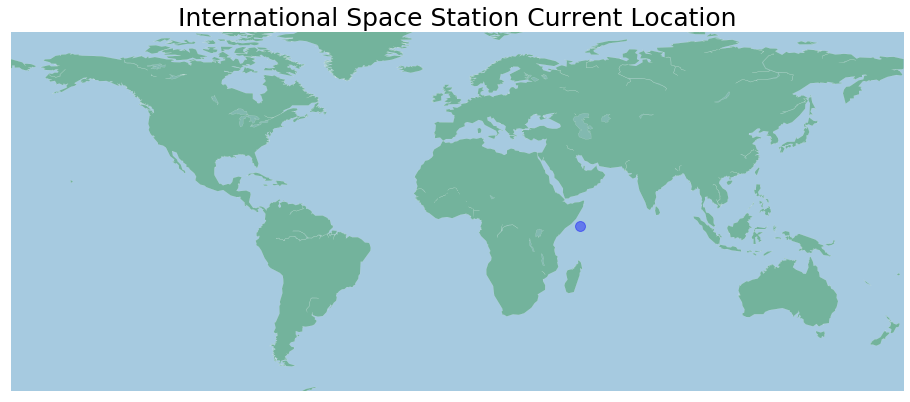

In [26]:
# pip install Basemap

import os
import conda

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

from mpl_toolkits.basemap import Basemap

# Set the dimensions of the figure
plt.figure(figsize=(16,8))

# Make the background map
m=Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='green', alpha=0.3)
m.drawcoastlines(linewidth=0.1, color="white")

# Mark the current Location of ISS
m.scatter(float(ISS_lat), 
          float(ISS_lon), 
          s=100, alpha=0.4,color='blue')

plt.title('International Space Station Current Location',fontsize=25)

# Collect Location Data for 1 revolution around the Earth


In [20]:
import datetime
import time

record_data = True

if record_data == True:
    #date_to_print = datetime.datetime.now().strftime("%Y%m%d")
    starttime=time.time()

    ISS_data = []
    
    while True: 
        req = requests.get(url='http://api.open-notify.org/iss-now.json')
        result = (req.json())

        ISS_data.append([result['timestamp'],
                                result['iss_position']['latitude'],
                                result['iss_position']['longitude']
                                ])

        
        # create a csv file for collecting data
        ISS_data_df = pd.DataFrame(ISS_data, columns=['timestamp','latitude', 'longitude'])
        ISS_data_df.to_csv('ISS_location_data.csv', index=None)
        
        # Stop Condition
        if len(ISS_data) > 80:
            break
            
        # let it sleep 60 seconds
        time.sleep(60.0 - ((time.time() - starttime) % 60.0))

# Visualize the Historical Data

In [27]:
# Load the Historical Data
ISS_flight_data = pd.read_csv('ISS_location_data.csv')

# Translate timestamp into readable format
from datetime import datetime
date_time = [datetime.fromtimestamp(i) for i in ISS_flight_data['timestamp']]

# Add date and time as a new column in the dataframe 
ISS_flight_data['DateTime'] = date_time

# add an plot size from oldest to newest
ISS_flight_data['index'] = range(1,len(ISS_flight_data)+1)
 
ISS_flight_data.head()

,timestamp,latitude,longitude,DateTime,index
0,1595781706,39.1167,-2.2728,2020-07-26 22:11:46,1
1,1595781767,41.3766,1.6198,2020-07-26 22:12:47,2
2,1595781826,43.4605,5.7642,2020-07-26 22:13:46,3
3,1595781886,45.3797,10.2473,2020-07-26 22:14:46,4
4,1595781946,47.0898,15.0447,2020-07-26 22:15:46,5


# Modelling the ISS Data

In [65]:
# Each dot on the map denotes one minute
# let's try to predict the future course of ISS

# USING LINEAR REGRESSION

ISS_train_set = ISS_flight_data.head(40)

from scipy import stats
slope, intercept, r_val, p_val, std_err = stats.linregress(x=ISS_train_set['longitude'],y=ISS_train_set['latitude'])

print('Intercept: ',intercept)
print('Slope: ',slope)
predefined_long = 147
predicted_value_LR = slope * predefined_long + intercept
print('Predicted Latitude for ',predefined_long,': ',predicted_value_LR)


Intercept:  62.78340864111574
Slope:  -0.41981580472588387
Predicted Latitude for  147 :  1.0704853464108126


In [66]:
# USING POLYNOMIAL REGRESSION

x = ISS_train_set['longitude']
y = ISS_train_set['latitude']
poly_regression = np.poly1d(np.polyfit(x, y, 3))

# Predict Latitude
predicted_latitude_PR =  poly_regression(predefined_long)
print('Predicted Latitude for Longitude ',predefined_long,': ',predicted_latitude_PR)

Predicted Latitude for Longitude  147 :  -26.861383200081804


# Plotting the Predicted values obtained using Linear and Polynomial    Regression

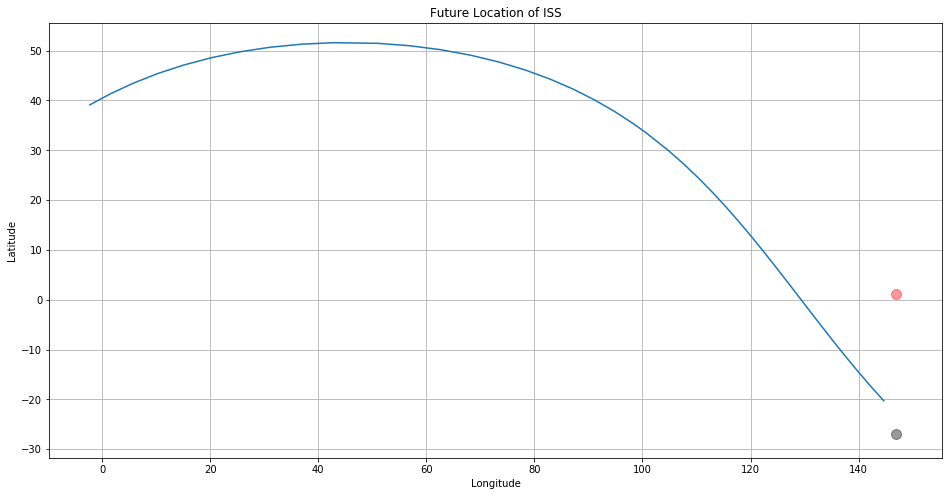

In [67]:
# Let's decide which model predicts the best value
plt.figure(figsize=(16,8))
plt.plot(ISS_train_set['longitude'],ISS_train_set['latitude'])
plt.title('Future Location of ISS')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()

plt.scatter(predefined_long,predicted_value_LR,s=100,alpha=0.4,color='red',label='Linear Regression')
plt.scatter(predefined_long,predicted_latitude_PR,s=100,alpha=0.4,color='black',label='Polynomial Regression')



In [68]:
# From the Visualization, it is concluded that the Polynomial Regression best fits the data.
# It gives accurate results for any value

# ACTUAL PATH of the ISS versus the PREDICTED PATH

Text(0.5, 1.0, 'International Space Station Current Location')

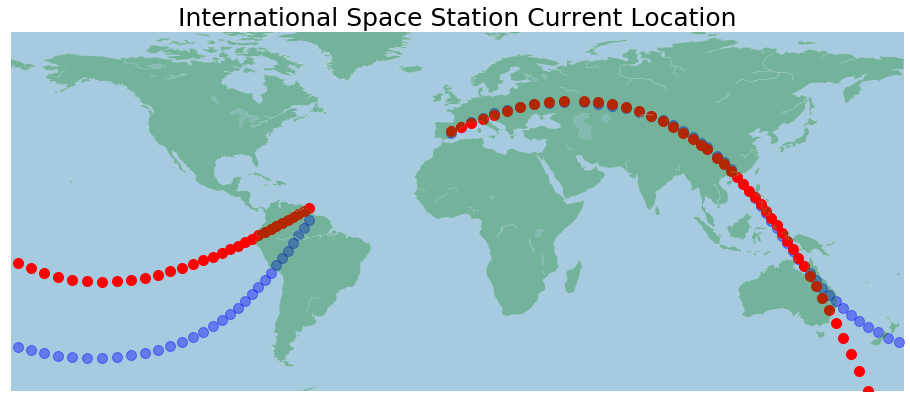

In [69]:
# Set the dimensions of the figure
plt.figure(figsize=(16,8))

# Make the background map
m=Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='green', alpha=0.3)
m.drawcoastlines(linewidth=0.1, color="white")


# Mark the Actual Path of ISS
m.scatter((ISS_flight_data['longitude']), 
          (ISS_flight_data['latitude']), 
          s=100, alpha=0.4,color='blue')

# Mark the Predicted Path of ISS
# Using Trained Polynomial Regression Model
longitude_predict = [i for i in ISS_flight_data['longitude']]
latitude_predict = []
for i in longitude_predict:
    latitude_predict.append(poly_regression(i))
    
m.scatter((longitude_predict), 
          (latitude_predict), 
          s=100, alpha=1,color='red')

plt.title('International Space Station Current Location',fontsize=25)